# Philippines Elections 2025 - Data Processing

This notebook aims to understand the election results and compare and contrast it with the opinion
polling that happened days before the election proper.

## Dataset

- Halalan 2025 Results
- Opinion Polling in the Philippines (Wikipedia)

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load and display the name mapping
name_mapping = pd.read_csv('data/processed/name_mapping.csv')
name_mapping.sort_values('Standardized Name')

,Original Name,Standardized Name
32,Abby Binay,Abby Binay
14,"BINAY, ABBY",Abby Binay
67,Allen Capuyan,Allen Capuyan
82,Amirah Lidasan,Amirah Lidasan
72,Angelo de Alban,Angelo De Alban
...,...,...
50,Vic Rodriguez,Vic Rodriguez
22,"RODRIGUEZ, ATTY. VIC",Vic Rodriguez
37,Willie Revillame,Willie Revillame
21,"REVILLAME, WILLIE WIL",Willie Revillame


In [14]:
actual_results = pd.read_csv('data/processed/actual_results.csv')
opinion_polls = pd.read_csv('data/processed/opinion_polls.csv')

In [15]:
# Display the top 12 actual winners (senators)
print("Top 12 Elected Senators:")
actual_results.head(12)

Top 12 Elected Senators:


,Rank,Candidate Name,Political Party,Number of Votes,Standardized Name
0,1st,"GO, BONG GO",(PDPLBN),26479597,Bong Go
1,2nd,"AQUINO, BAM",(KNP),20634871,Bam Aquino
2,3rd,"DELA ROSA, BATO",(PDPLBN),20263395,Bato dela Rosa
3,4th,"TULFO, ERWIN",(LAKAS),16813744,Erwin Tulfo
4,5th,"PANGILINAN, KIKO",(LP),15087278,Francis Kiko Pangilinan
5,6th,"MARCOLETA, RODANTE",(IND),14904190,Rodante Marcoleta
6,7th,"LACSON, PING",(IND),14855623,Ping Lacson
7,8th,"SOTTO, TITO",(NPC),14595834,Tito Sotto
8,9th,"CAYETANO, PIA",(NP),14305761,Pia Cayetano
9,10th,"VILLAR, CAMILLE",(NP),13356877,Camille Villar


In [16]:
# Display a sample of the opinion polls data
opinion_polls.head(24)


,Candidate,Party,"Mar 31–Apr 7, 2025 WR Numero","Apr 7–12, 2025 Arkipelago Analytics","Apr 10–16, 2025 OCTA","Apr 11–15, 2025 SWS","Apr 11–15, 2025 The Center","Apr 12–14, 2025 DZRH","Apr 20–24, 2025 OCTA","Apr 20–24, 2025 Pulse Asia","Apr 23–30, 2025 WR Numero","Apr 26–May 1, 2025 Arkipelago Analytics","Apr 28–May 3, 2025 The Center","May 1, 2025 Publicus Asia","May 2–6, 2025 SWS",Standardized Name
0,Bong Go,DuterTen (PDP),41.9,64.0,64.2,45.0,57.0,63.2,56.8,62.2,45.3,63.0,59.0,42,43.0,Bong Go
1,Erwin Tulfo,ABP (Lakas),43.4,55.0,61.2,43.0,44.0,50.4,52.7,42.4,48.7,55.0,47.6,28,45.0,Erwin Tulfo
2,Tito Sotto,ABP (NPC),29.8,44.0,43.3,33.0,54.3,41.8,42.3,41.1,37.0,42.0,54.0,28,37.0,Tito Sotto
3,Bato dela Rosa,DuterTen (PDP),38.7,49.0,40.4,32.0,46.0,50.7,40.8,41.0,36.8,47.0,49.3,32,31.0,Bato dela Rosa
4,Ben Tulfo,Independent,32.1,42.0,45.4,31.0,39.0,40.1,40.2,33.5,35.2,42.0,39.0,23,34.0,Ben Tulfo
5,Pia Cayetano,ABP (NP),34.7,43.0,39.5,33.0,44.5,36.3,39.1,29.9,36.6,41.0,45.7,28,30.0,Pia Cayetano
6,Ramon Bong Revilla,ABP (Lakas),27.4,40.5,38.7,31.0,25.0,34.3,38.1,35.6,29.5,39.0,27.0,11,29.0,Ramon Bong Revilla
7,Abby Binay,ABP (NPC),31.8,37.0,35.7,29.0,40.7,33.9,37.6,30.2,31.7,32.0,43.0,18,31.0,Abby Binay
8,Lito Lapid,ABP (NPC),34.1,41.0,36.9,34.0,32.0,38.9,35.6,32.2,34.8,38.7,30.0,14,34.0,Lito Lapid
9,Panfilo Lacson,ABP (ind),34.1,38.0,39.7,26.0,36.0,42.9,34.3,33.8,33.8,32.0,38.0,32,32.0,Ping Lacson


In [17]:
# Comparative Analysis: Polling Stations vs Actual Results
# Get the actual top 12 senators
actual_top12 = actual_results.head(12)['Standardized Name'].tolist()
print("Actual Top 12 Senators:")
for i, senator in enumerate(actual_top12, 1):
    print(f"{i}. {senator}")


Actual Top 12 Senators:
1. Bong Go
2. Bam Aquino
3. Bato dela Rosa
4. Erwin Tulfo
5. Francis Kiko Pangilinan
6. Rodante Marcoleta
7. Ping Lacson
8. Tito Sotto
9. Pia Cayetano
10. Camille Villar
11. Lito Lapid
12. Imee R. Marcos


In [18]:
# Function to get the top 12 candidates from a polling station
def get_top12_from_poll(poll_column):
    # Create a dataframe with just the candidate names and their poll results
    poll_df = opinion_polls[['Standardized Name', poll_column]].copy()
    # Remove rows with NaN values
    poll_df = poll_df.dropna(subset=[poll_column])
    # Sort by poll results in descending order
    poll_df = poll_df.sort_values(by=poll_column, ascending=False)
    # Return the top 12 candidates
    return poll_df.head(12)['Standardized Name'].tolist()


In [19]:
# Create a dataframe to store the comparison results
poll_columns = [col for col in opinion_polls.columns if col not in ['Candidate', 'Party', 'Standardized Name']]
comparison_results = []

# For each polling station
for poll_column in poll_columns:
    # Get the top 12 candidates from this poll
    poll_top12 = get_top12_from_poll(poll_column)

    # Count how many candidates from the actual top 12 are in this poll's top 12
    correct_count = sum(1 for candidate in poll_top12 if candidate in actual_top12)

    # Calculate accuracy percentage
    accuracy = (correct_count / 12) * 100

    # Add to results
    comparison_results.append({
        'Polling Station': poll_column,
        'Correct Predictions': correct_count,
        'Accuracy (%)': accuracy,
        'Predicted Top 12': poll_top12
    })

# Convert to dataframe
comparison_df = pd.DataFrame(comparison_results)


In [20]:
# Display the comparison results
print("Comparative Analysis: Polling Stations vs Actual Results")
comparison_display = comparison_df[['Polling Station', 'Correct Predictions', 'Accuracy (%)']]
comparison_display.sort_values('Accuracy (%)', ascending=False)


Comparative Analysis: Polling Stations vs Actual Results


,Polling Station,Correct Predictions,Accuracy (%)
0,"Mar 31–Apr 7, 2025 WR Numero",9,75.000000
2,"Apr 10–16, 2025 OCTA",9,75.000000
6,"Apr 20–24, 2025 OCTA",9,75.000000
8,"Apr 23–30, 2025 WR Numero",9,75.000000
9,"Apr 26–May 1, 2025 Arkipelago Analytics",9,75.000000
11,"May 1, 2025 Publicus Asia",9,75.000000
1,"Apr 7–12, 2025 Arkipelago Analytics",8,66.666667
3,"Apr 11–15, 2025 SWS",8,66.666667
4,"Apr 11–15, 2025 The Center",8,66.666667
5,"Apr 12–14, 2025 DZRH",8,66.666667


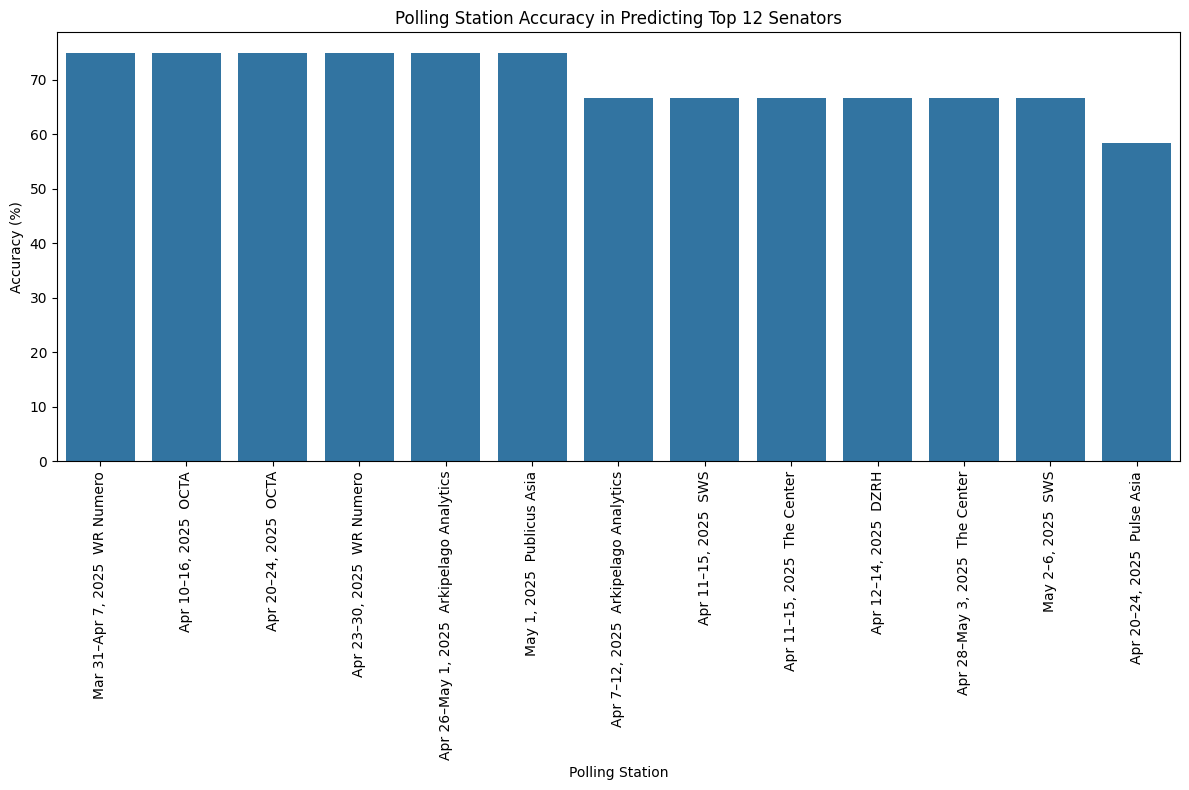

In [21]:
# Visualize the accuracy of each polling station
plt.figure(figsize=(12, 8))
sns.barplot(x='Polling Station', y='Accuracy (%)', data=comparison_df.sort_values('Accuracy (%)', ascending=False))
plt.xticks(rotation=90)
plt.title('Polling Station Accuracy in Predicting Top 12 Senators')
plt.tight_layout()
plt.show()


In [22]:
# Detailed analysis of each polling station's predictions
for index, row in comparison_df.iterrows():
    print(f"\nPolling Station: {row['Polling Station']}")
    print(f"Correct Predictions: {row['Correct Predictions']} out of 12 ({row['Accuracy (%)']}%)")

    print("\nPredicted Top 12:")
    for i, candidate in enumerate(row['Predicted Top 12'], 1):
        # Check if this candidate is in the actual top 12
        is_correct = candidate in actual_top12
        status = "✓" if is_correct else "✗"

        # Get the actual rank if the candidate is in the top 12
        actual_rank = actual_top12.index(candidate) + 1 if is_correct else "Not in top 12"

        print(f"{i}. {candidate} {status} (Actual Rank: {actual_rank})")



Polling Station: Mar 31–Apr 7, 2025  WR Numero
Correct Predictions: 9 out of 12 (75.0%)

Predicted Top 12:
1. Erwin Tulfo ✓ (Actual Rank: 4)
2. Bong Go ✓ (Actual Rank: 1)
3. Bato dela Rosa ✓ (Actual Rank: 3)
4. Pia Cayetano ✓ (Actual Rank: 9)
5. Lito Lapid ✓ (Actual Rank: 11)
6. Ping Lacson ✓ (Actual Rank: 7)
7. Ben Tulfo ✗ (Actual Rank: Not in top 12)
8. Abby Binay ✗ (Actual Rank: Not in top 12)
9. Tito Sotto ✓ (Actual Rank: 8)
10. Ramon Bong Revilla ✗ (Actual Rank: Not in top 12)
11. Camille Villar ✓ (Actual Rank: 10)
12. Bam Aquino ✓ (Actual Rank: 2)

Polling Station: Apr 7–12, 2025  Arkipelago Analytics
Correct Predictions: 8 out of 12 (66.66666666666666%)

Predicted Top 12:
1. Bong Go ✓ (Actual Rank: 1)
2. Erwin Tulfo ✓ (Actual Rank: 4)
3. Bato dela Rosa ✓ (Actual Rank: 3)
4. Tito Sotto ✓ (Actual Rank: 8)
5. Pia Cayetano ✓ (Actual Rank: 9)
6. Ben Tulfo ✗ (Actual Rank: Not in top 12)
7. Lito Lapid ✓ (Actual Rank: 11)
8. Ramon Bong Revilla ✗ (Actual Rank: Not in top 12)
9. Willie R

In [23]:
# Summary of polling station accuracy
print("\n=== SUMMARY OF POLLING STATION ACCURACY ===\n")

# Sort by accuracy
sorted_comparison = comparison_df.sort_values('Accuracy (%)', ascending=False)

# Most accurate polling stations
print("Most Accurate Polling Stations:")
for i, (_, row) in enumerate(sorted_comparison.head(3).iterrows(), 1):
    print(f"{i}. {row['Polling Station']}: {row['Correct Predictions']} correct ({row['Accuracy (%)']}%)")

# Least accurate polling stations
print("\nLeast Accurate Polling Stations:")
for i, (_, row) in enumerate(sorted_comparison.tail(3).iterrows(), 1):
    print(f"{i}. {row['Polling Station']}: {row['Correct Predictions']} correct ({row['Accuracy (%)']}%)")

# Overall average accuracy
avg_accuracy = comparison_df['Accuracy (%)'].mean()
print(f"\nAverage Accuracy Across All Polling Stations: {avg_accuracy:.2f}%")

# Most commonly missed candidates
print("\nCandidates in the Actual Top 12 Most Commonly Missed by Polling Stations:")
missed_counts = {}
for senator in actual_top12:
    missed_count = sum(1 for row in comparison_results if senator not in row['Predicted Top 12'])
    missed_counts[senator] = missed_count

# Sort by most missed
for senator, count in sorted(missed_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    if count > 0:
        miss_percentage = (count / len(comparison_results)) * 100
        print(f"- {senator}: Missed by {count} polling stations ({miss_percentage:.1f}%)")

# Most commonly incorrectly included candidates
print("\nCandidates Not in the Actual Top 12 Most Commonly Included by Polling Stations:")
incorrect_counts = {}
for row in comparison_results:
    for candidate in row['Predicted Top 12']:
        if candidate not in actual_top12:
            incorrect_counts[candidate] = incorrect_counts.get(candidate, 0) + 1

# Sort by most included
for candidate, count in sorted(incorrect_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    if count > 0:
        include_percentage = (count / len(comparison_results)) * 100
        print(f"- {candidate}: Incorrectly included by {count} polling stations ({include_percentage:.1f}%)")

print("\nConclusion:")
print("This analysis shows how accurately polling stations predicted the actual top 12 senators.")
print("The results highlight which polling stations were most reliable in their predictions")
print("and which candidates were consistently under or over-estimated in the polls.")



=== SUMMARY OF POLLING STATION ACCURACY ===

Most Accurate Polling Stations:
1. Mar 31–Apr 7, 2025  WR Numero: 9 correct (75.0%)
2. Apr 10–16, 2025  OCTA: 9 correct (75.0%)
3. Apr 20–24, 2025  OCTA: 9 correct (75.0%)

Least Accurate Polling Stations:
1. Apr 28–May 3, 2025  The Center: 8 correct (66.66666666666666%)
2. May 2–6, 2025  SWS: 8 correct (66.66666666666666%)
3. Apr 20–24, 2025  Pulse Asia: 7 correct (58.333333333333336%)

Average Accuracy Across All Polling Stations: 69.87%

Candidates in the Actual Top 12 Most Commonly Missed by Polling Stations:
- Imee R. Marcos: Missed by 13 polling stations (100.0%)
- Francis Kiko Pangilinan: Missed by 12 polling stations (92.3%)
- Rodante Marcoleta: Missed by 10 polling stations (76.9%)
- Bam Aquino: Missed by 7 polling stations (53.8%)
- Camille Villar: Missed by 2 polling stations (15.4%)

Candidates Not in the Actual Top 12 Most Commonly Included by Polling Stations:
- Ben Tulfo: Incorrectly included by 13 polling stations (100.0%)
-